# MCMQMC 2024 Tutorial
## Quasi-Monte Carlo Methods:  What, Why, and How?
### Fred J. Hickernell

This demo makes use of our QMCPy software package.  See [qmcpy.org](www.qmcpy.org) for more details.

### If you are running this on colab, run this cell below
### If you running this in Jupyter notebook and you have the environment set up, ignore this cell below

In [1]:
# If you are running this on colab, uncomment out the lines below and run them

'''
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
!sudo apt install cm-super
!pip install git+https://github.com/QMCSoftware/QMCSoftware.git@SURE2024
'''

'\n!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended\n!sudo apt install cm-super\n!pip install git+https://github.com/QMCSoftware/QMCSoftware.git@SURE2024\n'

### Import needed packages

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
from copy import deepcopy
import sympy as sy
import sympy.stats
import time
import pickle
figpath = 'MCQMC2024DataFigures/' #this path sends the figures to the directory that you want
savefigs = True  #save the figures on your disk if True
imgfrmt = 'pdf' #kind of format to save figures as
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']  #get the color cycle
[py_blue, py_orange, py_green, py_red] = color_cycle[0:4]

### Some LaTeX macros (hidden in math mode)
$
\newcommand{\vh}{\boldsymbol{h}}
\newcommand{\vt}{\boldsymbol{t}}
\newcommand{\vx}{\boldsymbol{x}}
\newcommand{\vX}{\boldsymbol{X}}
\newcommand{\cf}{\mathcal{F}}
\newcommand{\cu}{\mathcal{U}}
\newcommand{\dif}{\mathrm{d}}
\newcommand{\Ex}{\mathbb{E}}
\DeclareMathOperator{\disc}{disc}
\newcommand{\norm}[2][{}]{{\left \lVert #2 \right \rVert}_{#1}}
$

## Examples of ways to spread points on a hypercube

### Evenly spaced points in one dimension $(d=1)$
In one dimension it is easy to spread points evenly

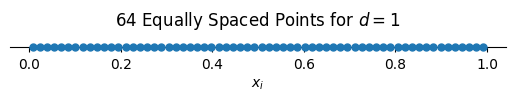

In [3]:
n = 64
xpts = np.linspace(1/(2*n), 1-1/(2*n), n) #equally spaced points between 0 and 1
fig, ax = plt.subplots()
ax.plot(xpts, np.zeros_like(xpts), '.', color = py_blue, markersize = 10, zorder=10, clip_on=False) 
ax.set_ylim([0, 3e-2])
ax.set_title(f"{n:.0f} Equally Spaced Points for $d=1$")
ax.set_xlabel("$x_i$")
ax.set_aspect(1)
ax.axes.get_yaxis().set_visible(False)  #turn off the tics on the vertical axis
ax.spines[['top','right','left']].set_visible(False)  #turn off the bounding box on the top and sides
if savefigs:
    fig.savefig(figpath+f"{n:.0f}equallyspacedpts."+imgfrmt,format=imgfrmt)

### Grids in dimension $d$
Our natural thought for higher dimensions is to use rectangular grids, but as the dimension, $d$, increases, the number of different values per coordinate decreases drastically.

In [4]:
def make_grid(d=3,nper=2):  #this function creates a nper^d x d matrix of grid points
    xpts = np.linspace(1/(2*nper), 1.0-1/(2*nper), nper)  #array of coordinate values
    xgrid = xpts  #initial grid
    n = nper  #initial length of grid
    for ii in range(1,d):
        xgrid0 = xgrid  #store the old grid
        xgrid = np.vstack((xgrid0,xpts[0]*np.ones((1,n))))  #stack the next coordinate
        for jj in range(1,nper):
            xgrid = np.hstack((xgrid,np.vstack((xgrid0,xpts[jj]*np.ones((1,n))))))
        n = n*nper  #update the length of the grid
    return xgrid.T  #take the transpose to that coordinates are columns

def plot_grid(xgrid, coord_to_plot = [0, 1], savefig = True, figpath = ''):
    n = xgrid.shape[0]
    d = xgrid.shape[1]
    coord_to_plot = np.minimum(coord_to_plot,[d,d]), #ensure that they are no more than d
    coord_to_plot = coord_to_plot[0]
    coord_to_plot = np.maximum(coord_to_plot,[1,1]), #ensure that they are no less than 1
    coord_to_plot = coord_to_plot[0]
    fig, ax = plt.subplots()
    ax.plot(xgrid[:,coord_to_plot[0]-1], xgrid[:,coord_to_plot[1]-1], '.', color = py_blue, markersize = 10, zorder=10, clip_on=False) 
    ax.set_title(f"{n:.0f} Grid Points for $d = ${d:.0f}")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel(r'$x_{i%d}$'%(coord_to_plot[0]),fontsize=14)
    ax.set_ylabel(r'$x_{i%d}$'%(coord_to_plot[1]),fontsize=14)
    ax.set_aspect(1)
    ax.grid(False)
    if savefigs:
        fig.savefig(figpath+f"{n:.0f}gridpts_d{d:.0f}."+imgfrmt,format=imgfrmt)


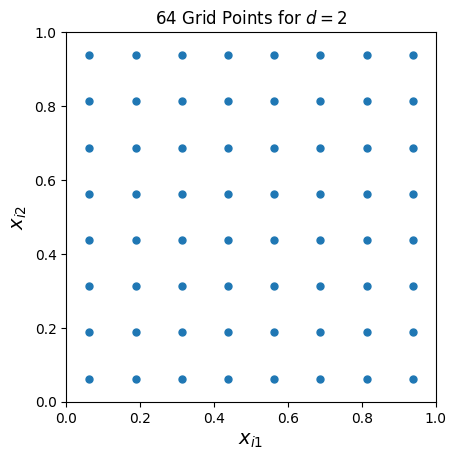

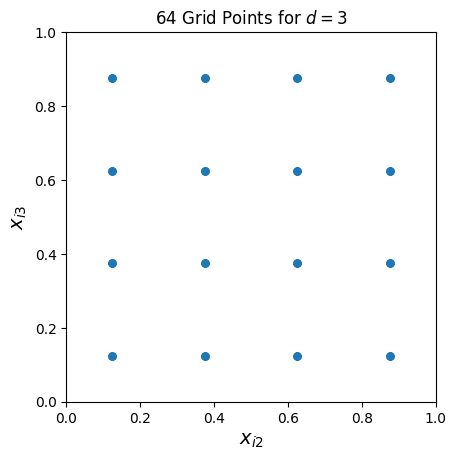

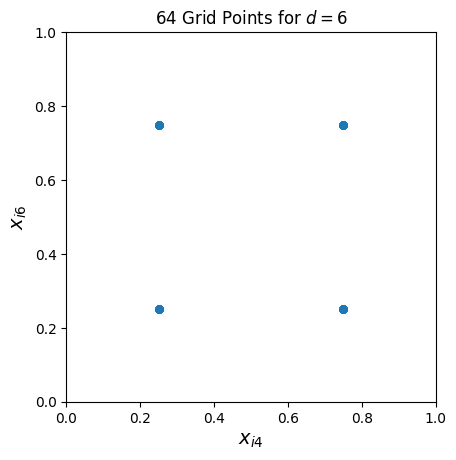

In [5]:
plot_grid(make_grid(2,8), [1,2], savefigs, figpath)
plot_grid(make_grid(3,4), [2,3], savefigs, figpath)
plot_grid(make_grid(6,2), [4,6], savefigs, figpath)

### Independent and identically distributed (IID) points
Since grids are bad, we can use IID points instead.  Note how they fill space better.

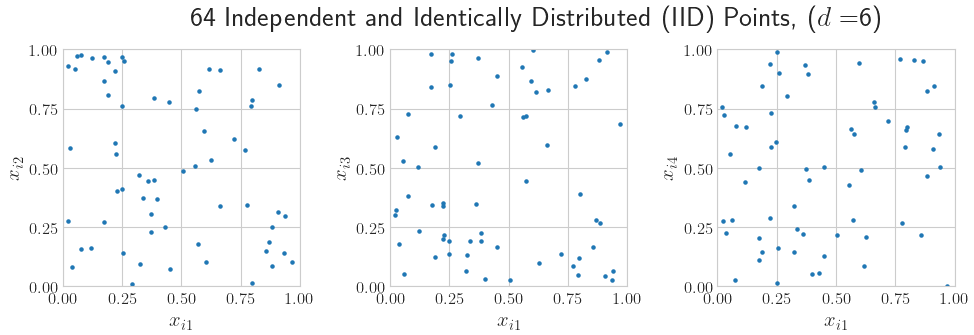

In [6]:
d = 6  #the dimension used for these examples
n = 64  #the sample size used for these examples
fig,ax = qp.plot_proj(qp.IIDStdUniform(d), n, d_horizontal = 1, d_vertical = np.arange(2,5), figfac = 10, \
                      fig_title = f"{n} Independent and Identically Distributed (IID) Points, ($d = ${d})")
if savefigs:
        fig.savefig(figpath+f"{n:.0f}iidpts_d{d:.0f}."+imgfrmt,format=imgfrmt)

### Low disrepancy points
There are several kinds of low discrepancy points, includng Sobol', lattice, and Halton.  Below we display one kind.

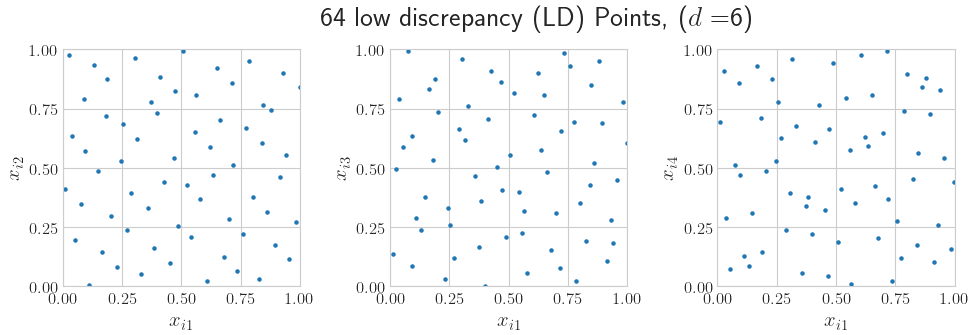

In [7]:
fig,ax = qp.plot_proj(qp.Sobol(d), n, d_horizontal = 1, d_vertical = np.arange(2,5), figfac = 10, \
                      fig_title = f"{n} low discrepancy (LD) Points, ($d = ${d})")
    #d_horizontal and d_vertical are the tuples of coordinates to plot
if savefigs:
        fig.savefig(figpath+f"{n:.0f}sobolpts_d{d:.0f}."+imgfrmt,format=imgfrmt)

### Integration Lattices

#### Constructing an integration lattice
$$
\vx_i = i \vh / n \ \pmod{1}, \qquad i = 0, \ldots, n-1
$$

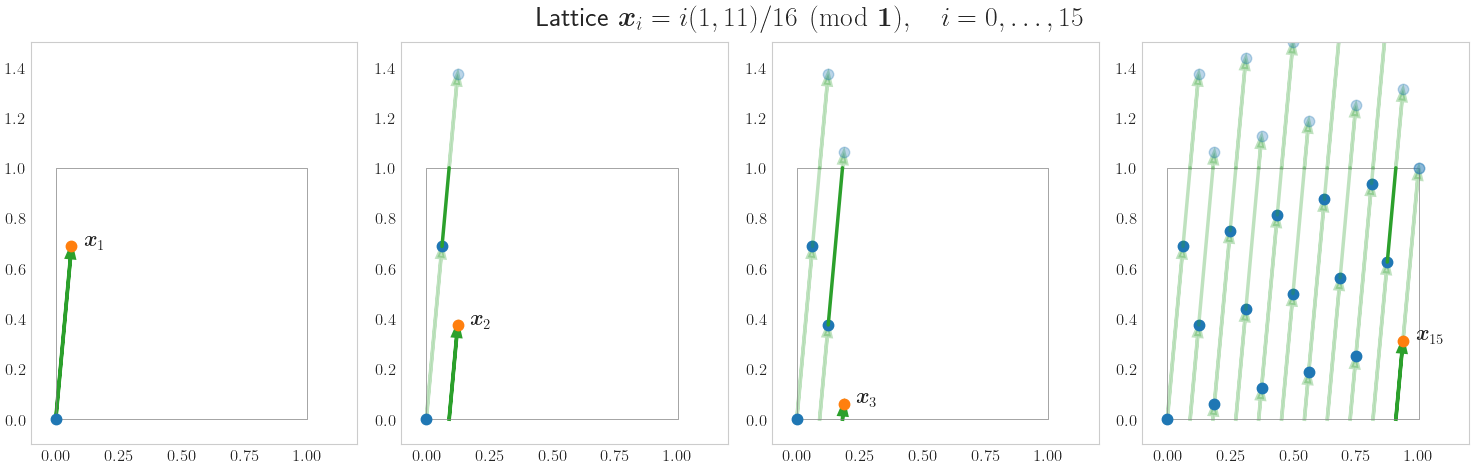

In [8]:
h_gen = np.array([1, 11])
n = 16
d = h_gen.size
x_lat = np.mod(np.arange(0,n).reshape(n,1)*h_gen.reshape(1,d)/n,1)
#x_lat = qp.Lattice(d,randomize = False).gen_samples(n)
dot_size = 15
line_width = 2.5
al_fade = 0.3
x_off = 0.05
an_ft = 15
arrow_style = {"color" : py_green, "head_width" : 0.03, "length_includes_head" : True, "linewidth" : line_width}
n_plt = 4
fig, ax = plt.subplots(1,n_plt,figsize = (15,5))
for ii in range(n_plt):
    ax[ii].set_xlim([-0.1, 1.2])
    ax[ii].set_ylim([-0.1, 1.5])
    ax[ii].set_aspect(1) 
    ax[ii].grid(False)
    ax[ii].plot([0,0,1,1,0],[0,1,1,0,0], linewidth = 0.5, color = "gray")
    
ax[0].plot(x_lat[0,0],x_lat[0,1],'.',markersize = dot_size)
ax[0].plot(x_lat[1,0],x_lat[1,1],'.',markersize = dot_size)
ax[0].arrow(x_lat[0,0],x_lat[0,1],h_gen[0]/n,h_gen[1]/n,**arrow_style)
ax[0].annotate(f"$\\boldsymbol{{x}}_1$",(x_lat[1,0]+x_off,x_lat[1,1]), fontsize = an_ft)


for jj in range(1,4):  #next three plots
    over_ctr = 0  #how many times higher than one
    ax[jj].plot(x_lat[0,0],x_lat[0,1],'.',color = py_blue, markersize = dot_size) #plot the origin
    x_next_vert = x_lat[0,1]+h_gen[1]/n  #how high the next point may go
    kk = 1  #next is the first point
    cond = (over_ctr < jj)  or ((jj == 3) & (kk < n))
    #print("jj = ",jj,"kk = ",kk,"cond =",cond)
    while cond :
        while x_next_vert < 1:  #as long as the next point does not go to high
            ax[jj].plot(x_lat[kk,0],x_lat[kk,1],'.',color = py_blue, markersize = dot_size)  #plot next point
            ax[jj].arrow(x_lat[kk-1,0],x_lat[kk-1,1],h_gen[0]/n,h_gen[1]/n,alpha = al_fade,**arrow_style)  #plot arrow to nexgt point
            x_next_vert = x_lat[kk,1]+h_gen[1]/n  #how high does the next point go
            kk += 1  #increment next point
        over_ctr +=1  #this next point will go over the vertical axis
        #print("over_ctr =",over_ctr)
        cond = (over_ctr < jj)  or ((jj == 3) & (kk < n-1)) #is this the last jump or the last figure
        #print("jj = ",jj,"kk = ",kk,"n =",n,"cond =",cond)
        xcross = x_lat[kk-1,0]+(1.-x_lat[kk-1,1])*h_gen[0]/h_gen[1]  #determine the crosssing point 
        if cond:  #if not over more than allowed number of times 
            ax[jj].plot([x_lat[kk-1,0],xcross],[x_lat[kk-1,1],1],'-',color = py_green, alpha = al_fade, linewidth = line_width)  #plot the bottom part of the arrow
            ax[jj].arrow(xcross,1,x_lat[kk,0]-xcross,x_lat[kk,1],alpha = al_fade,**arrow_style)  #plot the top part of the arrow
            ax[jj].arrow(xcross,0,x_lat[kk,0]-xcross,x_lat[kk,1],alpha = al_fade,**arrow_style)  #plot the top part of the wrapped around arrow
            ax[jj].plot(x_lat[kk,0],x_lat[kk,1],'.',color = py_blue, markersize = dot_size)  #plot the new point
        else:
            #print("jj = ",jj,"kk = ",kk,"n =",n,"cond =",cond)
            ax[jj].plot([x_lat[kk-1,0],xcross],[x_lat[kk-1,1],1],'-',color = py_green,linewidth = line_width)
            ax[jj].arrow(xcross,1,x_lat[kk,0]-xcross,x_lat[kk,1],alpha = al_fade,**arrow_style)
            ax[jj].arrow(xcross,0,x_lat[kk,0]-xcross,x_lat[kk,1],**arrow_style)
            ax[jj].annotate(f"$\\boldsymbol{{x}}_{{{kk}}}$",(x_lat[kk,0]+x_off,x_lat[kk,1]), fontsize = an_ft)
            ax[jj].plot(x_lat[kk,0],x_lat[kk,1],'.',color = py_orange, markersize = dot_size)  #plot the new point
        ax[jj].plot(x_lat[kk,0],1 + x_lat[kk,1],'.',color = py_blue, markersize = dot_size, alpha = al_fade)  #plot the new point before wrap around
        x_next_vert = x_lat[kk,1]+h_gen[1]/n
        kk += 1
        cond = (over_ctr < jj)  or ((jj == 3) & (kk < n))
        #print("jj = ",jj,"kk = ",kk,"n =",n,"cond =",cond)
ax[3].plot(1.,1. , '.',markersize = dot_size, color = py_blue, alpha = al_fade)
ax[3].plot(1.,1. , '.',markersize = dot_size, color = py_blue, alpha = al_fade)
ax[3].arrow(x_lat[-1,0],x_lat[-1,1],h_gen[0]/n,h_gen[1]/n,alpha = al_fade,**arrow_style)
        
fig.text(0.55,0.95,f"Lattice $\\boldsymbol{{x}}_i = i ({h_gen[0]},{h_gen[1]})/{n} \\pmod{{\\boldsymbol{{1}}}}, \\quad i = 0, \\ldots, {n-1}$", ha = 'center', va = 'center', fontsize = 20)
if savefigs:
        fig.savefig(figpath+f"{n:.0f}_lattice_construct_d{d:.0f}."+imgfrmt,format=imgfrmt)

#### Constructing a __shifted__ integration lattice
$$
\vx_i = i \vh / n + \boldsymbol{\Delta} \ \pmod{1}, \qquad i = 0, \ldots, n-1
$$

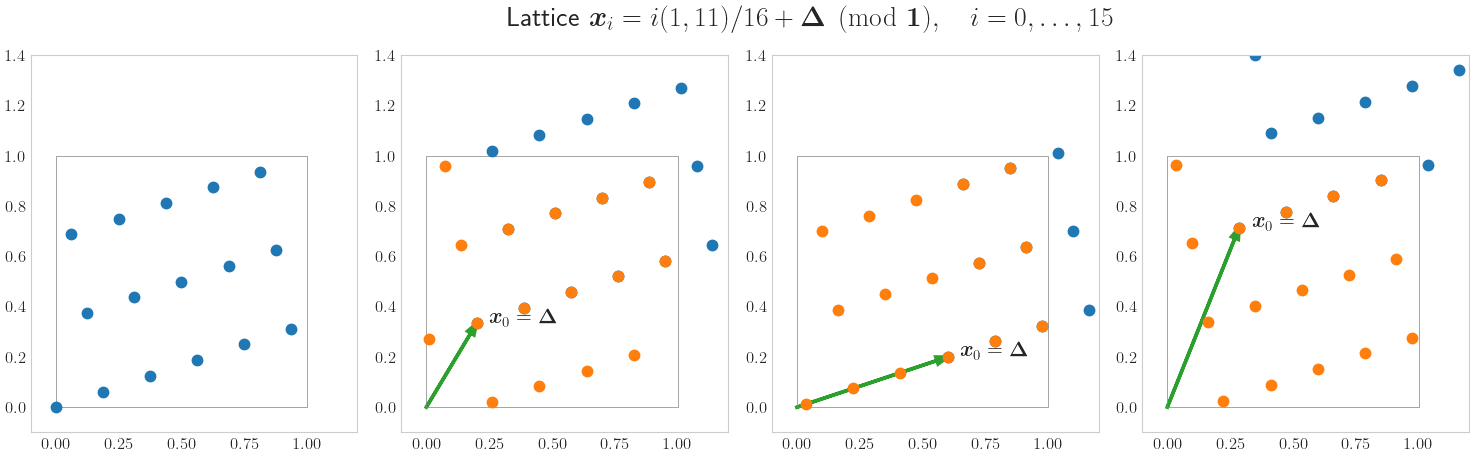

In [9]:
x_lat = x_lat[:,0:2]
n_plt = 4
fig, ax = plt.subplots(1,n_plt,figsize = (15,5))
for ii in range(n_plt):
    ax[ii].set_xlim([-0.1, 1.2])
    ax[ii].set_ylim([-0.1, 1.4])
    ax[ii].set_aspect(1) 
    ax[ii].grid(False)
    ax[ii].plot([0,0,1,1,0],[0,1,1,0,0], linewidth = 0.5, color = "gray")

shift = np.array([[1/5,1/3],[3/5,1/5],[2/7,5/7]])
    
ax[0].plot(x_lat[:,0],x_lat[:,1],'.',markersize = dot_size)

for ii in range(1,4):
    x_shlat = x_lat + shift[ii-1,:]
    x_shlatmod = np.mod(x_shlat,1)
    ax[ii].plot(x_shlat[:,0],x_shlat[:,1],'.',markersize = dot_size)
    ax[ii].plot(x_shlatmod[:,0],x_shlatmod[:,1],'.',markersize = dot_size)
    ax[ii].arrow(0,0,x_shlat[0,0],x_shlat[0,1],**arrow_style)
    ax[ii].annotate(f"$\\boldsymbol{{x}}_{{0}} = \\boldsymbol{{\\Delta}}$",(x_shlat[0,0]+x_off,x_shlat[0,1]), fontsize = an_ft)

fig.text(0.55,0.95,f"Lattice $\\boldsymbol{{x}}_i = i ({h_gen[0]},{h_gen[1]})/{n} + \\boldsymbol{{\\Delta}} \\pmod{{\\boldsymbol{{1}}}}, \\quad i = 0, \\ldots, {n-1}$", ha = 'center', va = 'center', fontsize = 20)
if savefigs:
        fig.savefig(figpath+f"{n:.0f}_shifted_lattice_construct_d{d:.0f}."+imgfrmt,format=imgfrmt)

#### van der Corput sequence, an extensible 1-D even sequence

/Users/fredhickernell/SoftwareRepositories/QMCSoftware/qmcpy/discrete_distribution/digital_net_b2/digital_net_b2.py:332


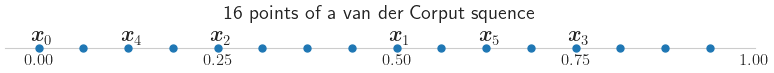

In [10]:
n = 16
xoff = -0.01
yoff = 0.01
xpts = qp.Sobol(1,randomize =  False).gen_samples(n) #equally spaced points between 0 and 1
fig, ax = plt.subplots()
ax.plot(xpts, np.zeros_like(xpts), '.', color = py_blue, markersize = 10, zorder=10, clip_on=False) 
ax.set_ylim([0, 3e-2])
ax.set_title(f"{n:.0f} points of a van der Corput squence")
#ax.set_xlabel("$x_i$")
ax.set_aspect(1)
ax.axes.get_yaxis().set_visible(False)  #turn off the tics on the vertical axis
ax.grid(False)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.spines[['top','right','left']].set_visible(False)  #turn off the bounding box on the top and sides
for ii in range(6):
    ax.annotate(f"$\\boldsymbol{{x}}_{{{ii}}}$",(xpts[ii] + xoff, yoff), fontsize = an_ft)
if savefigs:
    fig.savefig(figpath+f"{n:.0f}vandercorputpts."+imgfrmt,format=imgfrmt)


#### Constructing an __extensible__ shifted integration lattice
$$
\vx_i = i \vh / n + \boldsymbol{\Delta} \ \pmod{1}, \qquad i = 0, \ldots, n-1
$$

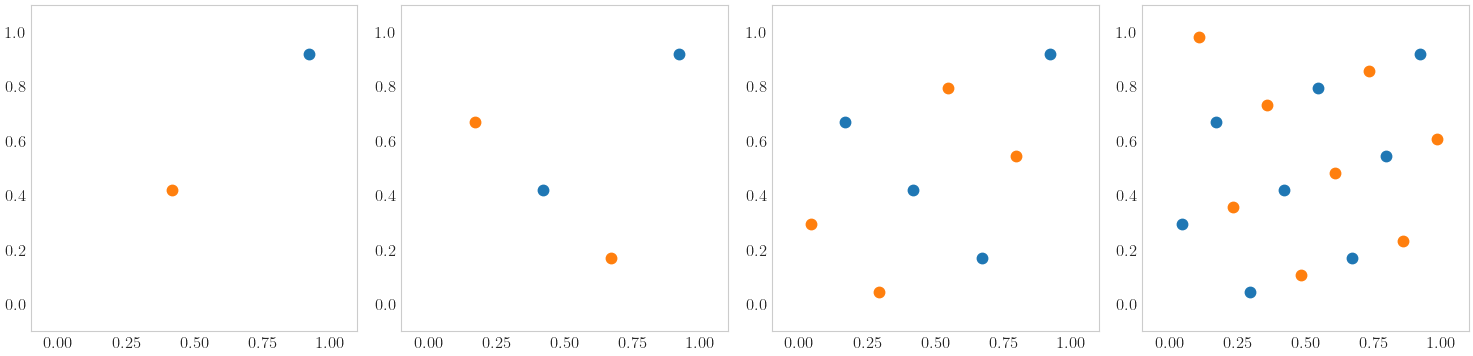

In [11]:
n =  16
x_lat = qp.Lattice(2, seed = 47).gen_samples(n)
n_plt = 4
fig, ax = plt.subplots(1,n_plt,figsize = (15,5))

for ii in range(n_plt):
    ax[ii].set_xlim([-0.1, 1.1])
    ax[ii].set_ylim([-0.1, 1.1])
    ax[ii].set_aspect(1) 
    ax[ii].grid(False)
    nstart = 0
    ax[ii].plot(x_lat[0:2**ii,0],x_lat[0:2**ii,1],'.',color = color_cycle[0], markersize = dot_size)
    ax[ii].plot(x_lat[2**ii:2**(ii+1),0],x_lat[2**ii:2**(ii+1),1],'.',color = color_cycle[1], markersize = dot_size)

#fig.text(0.55,0.95,f"Lattice $\\boldsymbol{{x}}_i = i ({h_gen[0]},{h_gen[1]})/{n} + \\boldsymbol{{\\Delta}} \\pmod{{1}}, \\quad i = 0, \\ldots, {n-1}$", ha = 'center', va = 'center', fontsize = 20)
if savefigs:
        fig.savefig(figpath+f"{n:.0f}_extensible_shifted_lattice_construct_d{d:.0f}."+imgfrmt,format=imgfrmt)

### Digital sequences

#### Digital sequences cover tiles

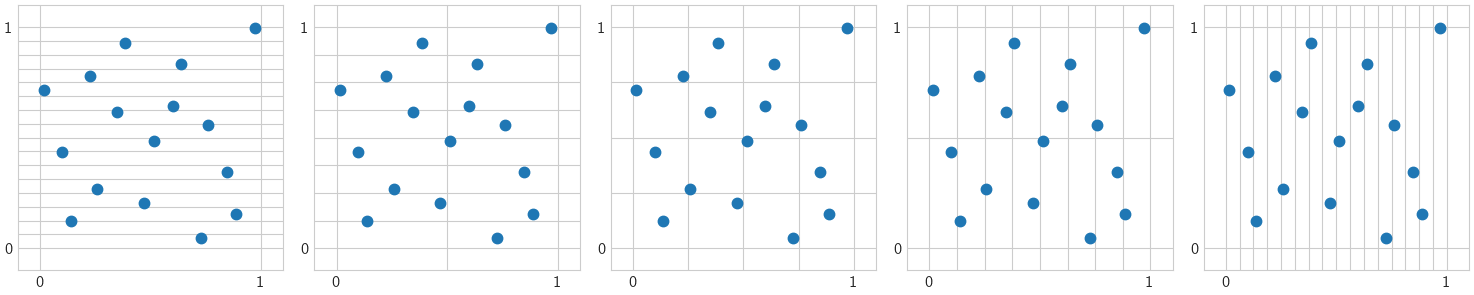

In [12]:
n_plt = 5
n = 2**(n_plt-1)
x_sob = qp.Sobol(2, seed = 29).gen_samples(n)
fig, ax = plt.subplots(1,n_plt,figsize = (15,5))

for ii in range(n_plt):
    ax[ii].set_xlim([-0.1, 1.1])
    ax[ii].set_ylim([-0.1, 1.1])
    xticklabels = [0]
    for jj in range(2**ii-1):
        xticklabels.append("")
    xticklabels.append(1)
    ax[ii].set_xticks(np.linspace(0,1,2**ii+1),xticklabels)
    yticklabels = [0]
    for jj in range(2**(n_plt-ii-1)-1):
        yticklabels.append("")
    yticklabels.append(1)
    ax[ii].set_yticks(np.linspace(0,1,2**(n_plt-ii-1)+1),yticklabels)
    ax[ii].set_aspect(1) 
    #ax[ii].grid(False)
    ax[ii].plot(x_sob[:,0],x_sob[:,1],'.',color = color_cycle[0], markersize = dot_size)

#fig.text(0.55,0.95,f"Sobol $\\boldsymbol{{x}}_i = i ({h_gen[0]},{h_gen[1]})/{n} + \\boldsymbol{{\\Delta}} \\pmod{{1}}, \\quad i = 0, \\ldots, {n-1}$", ha = 'center', va = 'center', fontsize = 20)
if savefigs:
        fig.savefig(figpath+f"{n:.0f}_sobol_sequence_d{d:.0f}."+imgfrmt,format=imgfrmt)

#### __Randomly Scrambled__ digital sequences still cover tiles

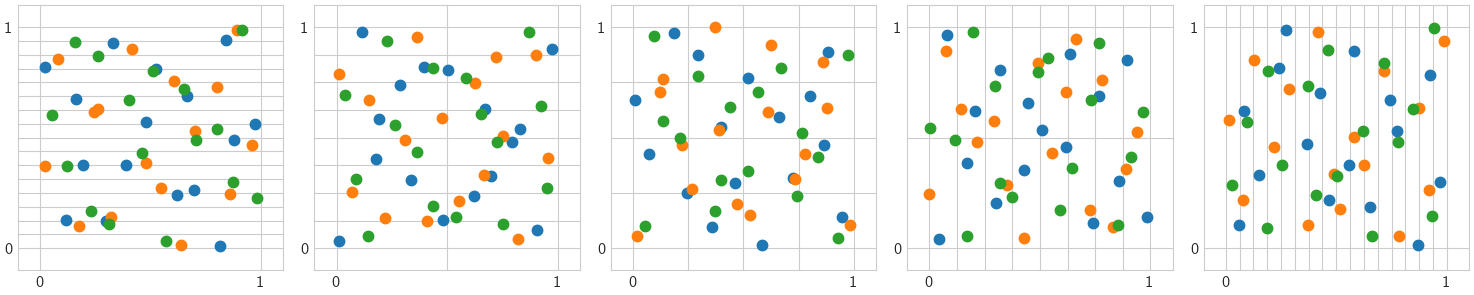

In [13]:
n_plt = 5
d = 2
n = 2**(n_plt-1)
fig, ax = plt.subplots(1,n_plt,figsize = (15,5))
n_scr = 3
for ii in range(n_plt):
    ax[ii].set_xlim([-0.1, 1.1])
    ax[ii].set_ylim([-0.1, 1.1])
    xticklabels = [0]
    for jj in range(2**ii-1):
        xticklabels.append("")
    xticklabels.append(1)
    ax[ii].set_xticks(np.linspace(0,1,2**ii+1),xticklabels)
    yticklabels = [0]
    for jj in range(2**(n_plt-ii-1)-1):
        yticklabels.append("")
    yticklabels.append(1)
    ax[ii].set_yticks(np.linspace(0,1,2**(n_plt-ii-1)+1),yticklabels)
    ax[ii].set_aspect(1) 
    #ax[ii].grid(False)
    for kk in range(n_scr):
        x_sob = qp.Sobol(d).gen_samples(n)
        ax[ii].plot(x_sob[:,0],x_sob[:,1],'.',color = color_cycle[kk], markersize = dot_size)

#fig.text(0.55,0.95,f"Sobol $\\boldsymbol{{x}}_i = i ({h_gen[0]},{h_gen[1]})/{n} + \\boldsymbol{{\\Delta}} \\pmod{{1}}, \\quad i = 0, \\ldots, {n-1}$", ha = 'center', va = 'center', fontsize = 20)
if savefigs:
        fig.savefig(figpath+f"{n:.0f}_{kk}th_scrambled_sobol_sequence_d{d:.0f}."+imgfrmt,format=imgfrmt)

## Discrepancy

### Compute the discrepancy

#### Function to compute the discrepancy

In [14]:
def discrep(x, weights = 1, disc_kind = "C", domain = np.array([0,1]), measure_time = False, mem_limit = 2**25, IID_Flag = False):
    '''
        x = n x d numpy array of points that you want to evaluate the discrepancy of
        weighs = coordinate weights
        disc_kind = flavor of discrepancy, default is centered
        domain = domain on which the discrepancy is defined
        mem_limit = number of floating point numbers that can be easily handled in memory to avoid for loops
        IID_Flag = True if you want to compute the root mean squared discrepancy of IID points
    '''
    
    if measure_time:
        start_time = time.time()
    if x.ndim == 1:  #ensure that x is a two dimensional array, get n and d
        x = x.reshape(x.size,1)
        d = 1
        n = x.size
    else:
        n, d = x.shape

    #print("n =", n, "d = ", d)
    
    weights = np.array(weights).reshape(-1)  #turn the weights into a one-dimensional array
    if len(weights) >= d:  #use the first d weights
        weights = weights[:d]
    else:  #or just propagate the first one
        weights = weights[0] * np.ones(d)

    if disc_kind.lower().startswith("c"):
        dbl_integ_fun = lambda weights : (1 + (weights/12)).prod()
        sngl_integ_fun = lambda x, weights : (1 + (0.5*weights)*(abs(x - .5)*(1 - abs(x -.5)))).prod(axis=1)
        gram_fun = lambda x, y, weights : (1 + (0.5*weights)*(abs(x - .5) + abs(y - .5) - abs(x - y))).prod(axis=2)
        diag_integ_fun = lambda weights : (1 + (weights/4)).prod()
 
    if IID_Flag:  #root mean square discrepancy of IID points
        out = np.sqrt((diag_integ_fun(weights) - dbl_integ_fun(weights))/n)
    else:  #discrepancy of actual points input
        #compute the double integral
        dbl_integ = dbl_integ_fun(weights)

        #compute the sum of the single integral and the double sum
        sngl_integ_sum = 0
        dbl_sum = 0
        if x[0,0] != None:  #the discrepancy of some points
            len_chunk = np.floor(np.sqrt(mem_limit/d)).astype('int')
            n_chunk = np.ceil(n/len_chunk).astype('int')
            for ii in range(n_chunk):
                n_ii_start = ii*len_chunk
                n_ii_end = np.array([n,(ii+1)*len_chunk]).min()
                n_ii_batch = n_ii_end - n_ii_start
                if n_ii_batch > 0:
                    x_chunk = x[n_ii_start:n_ii_end,:]
                    sngl_integ_sum  += sngl_integ_fun(x_chunk,weights).sum(axis = 0)
                    x_chunk = x_chunk.reshape(n_ii_batch,1,d)
                    y_chunk = x_chunk.reshape(1,n_ii_batch,d)
                    dbl_sum += gram_fun(x_chunk,y_chunk,weights).sum()
                    for jj in range(ii+1,n_chunk):
                        n_jj_start = jj*len_chunk
                        n_jj_end = np.array([n,(jj+1)*len_chunk]).min()
                        n_jj_batch = n_jj_end - n_jj_start
                        if n_jj_batch > 0:
                            y_chunk = x[n_jj_start:n_jj_end,:].reshape(1,n_jj_batch,d)
                            dbl_sum += 2*gram_fun(x_chunk,y_chunk,weights).sum()
            sngl_integ_sum  *= (2/n)
            dbl_sum *= (1/(n**2)) 
        # print(dbl_integ,sngl_integ_sum,dbl_sum)
        out = np.sqrt(dbl_integ -  sngl_integ_sum + dbl_sum)

    if measure_time:  #if we are measuring time
        total_time = time.time() - start.time
        out = [out, total_time]
    return out

#### Discrepancy experiment

In [15]:
n_vec = 2**np.arange(14)
d_vec = [1, 4, 16, 64]
n_max = np.max(n_vec)
d_max = np.max(d_vec)
xpts = qp.Sobol(d_max, seed = 29).gen_samples(n_max)
x_null = np.array([[None for ii in range(d_max)]])
un_disc = np.zeros((len(n_vec),len(d_vec)))
wt_disc = np.zeros((len(n_vec),len(d_vec)))
iid_un_disc = np.zeros((len(n_vec),len(d_vec)))
iid_wt_disc = np.zeros((len(n_vec),len(d_vec)))
wts = (np.arange(d_max)+1.)**-2.
null_un_disc = np.zeros(len(d_vec))
null_wt_disc = np.zeros(len(d_vec))
for ii, d in enumerate(d_vec):
    null_un_disc[ii] = discrep(x_null[:,:d], 1, 'centered')
    null_wt_disc[ii] = discrep(x_null[:,:d], wts, 'centered')
    for jj, n in enumerate(n_vec):
        if (jj == 0) or (n == n_max):
            print("Starting d =",d,", n=",n)
        un_disc[jj,ii] = discrep(xpts[:n,:d],1, 'centered')
        wt_disc[jj,ii] = discrep(xpts[:n,:d], wts, 'centered')
        iid_un_disc[jj,ii] = discrep(xpts[:n,:d], 1, 'centered', IID_Flag = True)
        iid_wt_disc[jj,ii] = discrep(xpts[:n,:d], wts, 'centered', IID_Flag = True)

out_filename = f'CtrDisc_dmax_{d_max}_nmax_{n_max}.pkl'
stored_vars  = [un_disc,wt_disc,iid_un_disc,iid_wt_disc,null_un_disc,null_wt_disc,d_vec,n_vec]
with open(figpath+out_filename,'wb') as myfile: 
    pickle.dump(stored_vars,myfile)  #save numerical output as a pickle file
print("Finished")

Starting d = 1 , n= 1
Starting d = 1 , n= 8192
Starting d = 4 , n= 1
Starting d = 4 , n= 8192
Starting d = 16 , n= 1
Starting d = 16 , n= 8192
Starting d = 64 , n= 1
Starting d = 64 , n= 8192
Finished


### Plot discrepancy

#### Input data for plotting

In [16]:
n_max = 2**13
d_max = 64
out_filename = f'CtrDisc_dmax_{d_max}_nmax_{n_max}.pkl'
with open(figpath+out_filename,'rb') as myfile: 
    un_disc,wt_disc,iid_un_disc,iid_wt_disc,null_un_disc,null_wt_disc,d_vec,n_vec = pickle.load(myfile) #load in all the data

#### Draw the plots

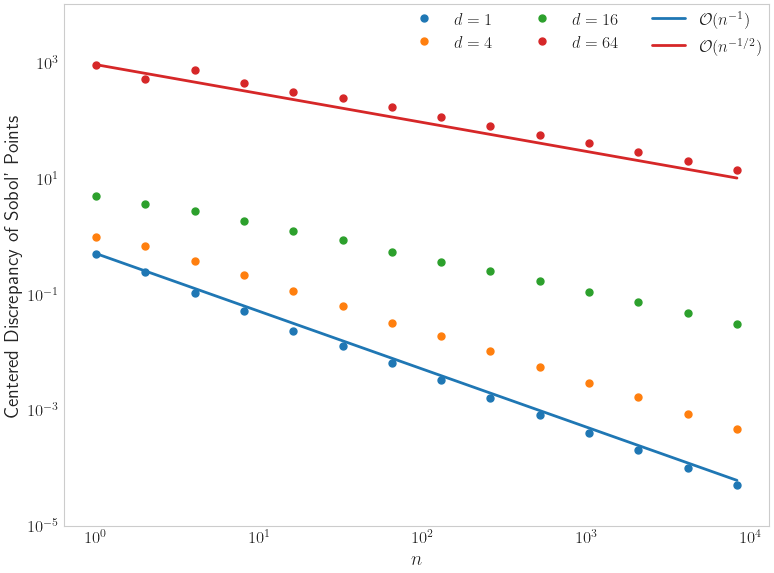

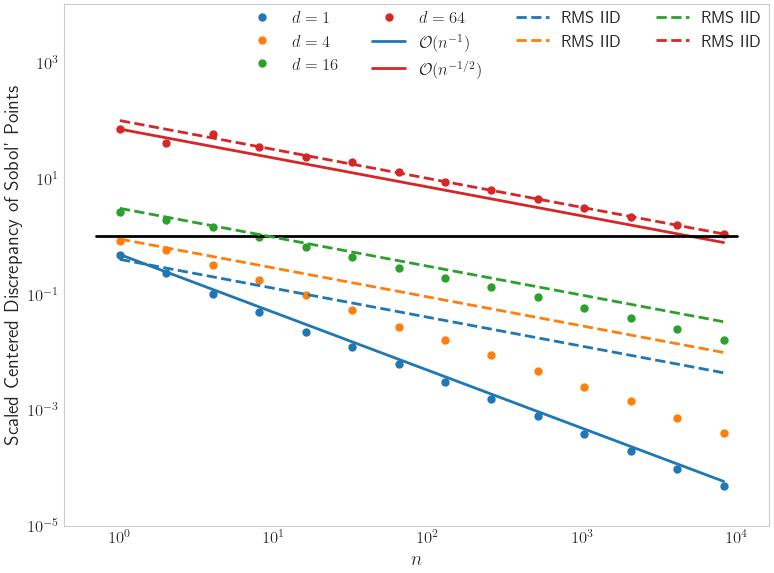

In [17]:
#plot raw discrepancy
fig, ax = plt.subplots()
for ii, d in enumerate(d_vec):
    ax.loglog(n_vec,un_disc[:,ii],'.', markersize = 10, label = f"$d = {{{d}}}$")
ax.loglog(n_vec[[0,-1]], un_disc[0,0]*np.array([1., n_vec[0]/n_vec[-1]]),'-', color = py_blue, label = f"$\\mathcal{{O}}(n^{{-1}})$")
ax.loglog(n_vec[[0,-1]], un_disc[0,-1]*np.array([1., np.sqrt(n_vec[0]/n_vec[-1])]),'-', color = color_cycle[ii], label = f"$\\mathcal{{O}}(n^{{-1/2}})$")
ax.set_xlabel(f"${{n}}$",fontsize=14)
ax.set_ylabel(f"Centered Discrepancy of Sobol' Points",fontsize=14)
ax.set_ylim([1e-5,1e4])
ax.legend(loc='upper right', ncol = 3, frameon = False)
ax.grid(False)
plt.subplots_adjust(top=0.95,right = 0.95)
if savefigs:
        fig.savefig(figpath+f"SobolCtrDisc_n_{n_max}_d{d_max}."+imgfrmt,format=imgfrmt)

#plot scaled discrepancy
sc_un_disc = un_disc/null_un_disc
sc_iid_un_disc = iid_un_disc/null_un_disc
fig, ax = plt.subplots()
for ii, d in enumerate(d_vec):
    ax.loglog(n_vec,sc_un_disc[:,ii],'.', markersize = 10, label = f"$d = {{{d}}}$")
ax.loglog(n_vec[[0,-1]], sc_un_disc[0,0]*np.array([1., n_vec[0]/n_vec[-1]]),'-', color = py_blue, label = f"$\\mathcal{{O}}(n^{{-1}})$")
ax.loglog(n_vec[[0,-1]], sc_un_disc[0,-1]*np.array([1., np.sqrt(n_vec[0]/n_vec[-1])]),'-', color = color_cycle[ii], label = f"$\\mathcal{{O}}(n^{{-1/2}})$")
ax.loglog([0.7,1e4], [1.,1], '-', color = 'black')
ax.set_xlabel(f"${{n}}$",fontsize=14)
ax.set_ylabel(f"Scaled Centered Discrepancy of Sobol' Points",fontsize=14)
ax.set_ylim([1e-5,1e4])
ax.grid(False)
ax.legend(loc='upper right', ncol = 4, frameon = False)
plt.subplots_adjust(top=0.95,right = 0.95)

if savefigs:
        fig.savefig(figpath+f"SobolScaledCtrDisc_n_{n_max}_d{d_max}."+imgfrmt,format=imgfrmt)

for ii, d in enumerate(d_vec):  #Add IID scaled discrepancy
    ax.loglog(n_vec[[0,-1]], sc_iid_un_disc[0,ii]*np.array([1., np.sqrt(n_vec[0]/n_vec[-1])]),'--', color = color_cycle[ii], label = f"RMS IID")
ax.grid(False)
ax.legend(loc='upper right', ncol = 4, frameon = False)

plt.show()
if savefigs:
        fig.savefig(figpath+f"IIDSobolScaledCtrDisc_n_{n_max}_d{d_max}."+imgfrmt,format=imgfrmt)



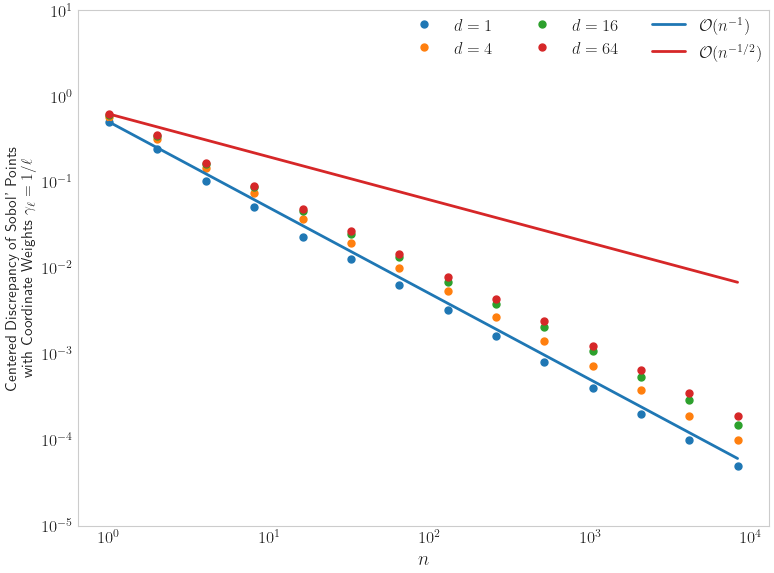

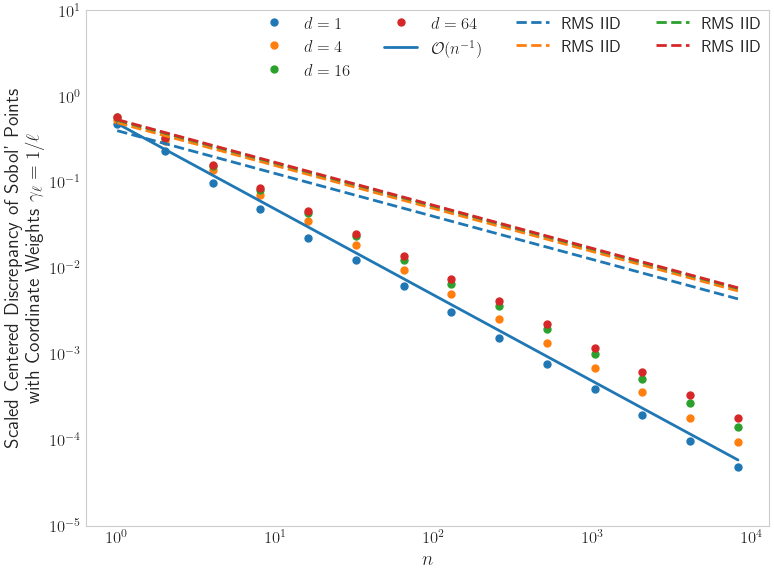

In [18]:
#plot raw weighted discrepancy
fig, ax = plt.subplots()
for ii, d in enumerate(d_vec):
    ax.loglog(n_vec,wt_disc[:,ii],'.', markersize = 10, label = f"$d = {{{d}}}$")
ax.loglog(n_vec[[0,-1]], wt_disc[0,0]*np.array([1., n_vec[0]/n_vec[-1]]),'-', color = py_blue, label = f"$\\mathcal{{O}}(n^{{-1}})$")
ax.loglog(n_vec[[0,-1]], wt_disc[0,-1]*np.array([1., np.sqrt(n_vec[0]/n_vec[-1])]),'-', color = color_cycle[ii], label = f"$\\mathcal{{O}}(n^{{-1/2}})$")
ax.set_xlabel(f"${{n}}$",fontsize=14)
ax.set_ylabel(f"Centered Discrepancy of Sobol' Points \n with Coordinate Weights $\gamma_\ell = 1/\ell$",fontsize=11)
ax.set_ylim([1e-5,1e1])
ax.legend(loc='upper right', ncol = 3, frameon = False)
ax.grid(False)
plt.subplots_adjust(top=0.95, right=0.95, left = 0.15)
if savefigs:
        fig.savefig(figpath+f"SobolWtCtrDisc_n_{n_max}_d{d_max}."+imgfrmt,format=imgfrmt)

#plot scaled discrepancy
sc_wt_disc = wt_disc/null_wt_disc
sc_iid_wt_disc = iid_wt_disc/null_wt_disc
fig, ax = plt.subplots()
for ii, d in enumerate(d_vec):
    ax.loglog(n_vec,sc_wt_disc[:,ii],'.', markersize = 10, label = f"$d = {{{d}}}$")
ax.loglog(n_vec[[0,-1]], sc_wt_disc[0,0]*np.array([1., n_vec[0]/n_vec[-1]]),'-', color = py_blue, label = f"$\\mathcal{{O}}(n^{{-1}})$")
#ax.loglog(n_vec[[0,-1]], sc_wt_disc[0,-1]*np.array([1., np.sqrt(n_vec[0]/n_vec[-1])]),'-', color = color_cycle[ii], label = f"$\\mathcal{{O}}(n^{{-1/2}})$")
#ax.loglog([0.7,1e4], [1.,1], '-', color = 'black')
ax.set_xlabel(f"${{n}}$",fontsize=14)
ax.set_ylabel(f"Scaled Centered Discrepancy of Sobol' Points \n with Coordinate Weights $\gamma_\ell = 1/\ell$",fontsize=14)
ax.set_ylim([1e-5,1e1])
ax.grid(False)
ax.legend(loc='upper right', ncol = 4, frameon = False)
plt.subplots_adjust(top=0.95, right=0.95, left = 0.15)

if savefigs:
        fig.savefig(figpath+f"SobolScaledWtCtrDisc_n_{n_max}_d{d_max}."+imgfrmt,format=imgfrmt)

for ii, d in enumerate(d_vec):  #Add IID scaled discrepancy
    ax.loglog(n_vec[[0,-1]], sc_iid_wt_disc[0,ii]*np.array([1., np.sqrt(n_vec[0]/n_vec[-1])]),'--', color = color_cycle[ii], label = f"RMS IID")
ax.grid(False)
ax.legend(loc='upper right', ncol = 4, frameon = False)

plt.show()
if savefigs:
        fig.savefig(figpath+f"IIDSobolScaledWtCtrDisc_n_{n_max}_d{d_max}."+imgfrmt,format=imgfrmt)



## Variable Transformations

### Asian Option Example

In [19]:
option_param = {"call_put" : 'call',
                "start_price" : 100, 
                "strike_price" : 125,
                "volatility" : .45,
                "interest_rate" : .05,
                "t_final" : 1 
               }
d = 4 

In [20]:
aco = qp.AsianOption(qp.DigitalNetB2(4))
print(aco)



AttributeError: 'AsianOption' object has no attribute 'dim_frac'

In [ ]:
qp.util.stop_notebook()

## Kernel Density Estimation

### Gaussian kernel

In [ ]:
def kernel(y):
    return np.exp(-y*y)/np.sqrt(np.pi)

In [ ]:
ypts = np.linspace(-5,5,500)
bandwidth = [0.5, 1, 2]
nband = len(bandwidth)
fig,ax = plt.subplots(1,3,figsize=(5*nband,5))
for ii in range(nband):
    ax[ii].plot(ypts,kernel(ypts/bandwidth[ii])/bandwidth[ii])
    ax[ii].grid(False)
    ax[ii].set_ylim([-0.05, 1.2])
    ax[ii].set_xlabel(r'$y$',fontsize=20)
    if (ii == 0):
        ax[ii].set_ylabel(r'$\widetilde{k}(y) = \exp(-(y/h)^2)/(\sqrt{\pi}h), \ h = {%0.1f}$'%bandwidth[ii],fontsize=20)
    else:
        ax[ii].set_ylabel(r'$h = {%0.1f}$'%bandwidth[ii],fontsize=20)
if savefigs:
        fig.savefig(figpath+"kernel."+imgfrmt,format=imgfrmt)

### Numerical experiment

#### Generate some $\vx_i$

In [ ]:
d = 3
coord_wts = 2.**(-np.array(range(0,d)))
n = 2**12
iidpts = qp.IIDStdUniform(d).gen_samples(n)
print("iid pts",iidpts)
wtiidpts = np.multiply(iidpts,coord_wts)
print(wtiidpts)
sobpts = qp.Sobol(d).gen_samples(n)
print("sobol pts",sobpts)

#### Generate some $y_i=f(x_i)$ points
$
f(\vx) = 10 \exp(- w_1x_1 - \cdots - w_d x_d) \sin(w_1x_1 + \cdots +w_d x_d)
$

In [ ]:
def testfun(x,coord_wts = 1): # function f(x) defines the random variable
    wtx = np.multiply(x,coord_wts)
    y = 10*np.exp(-wtx.sum(1))*np.sin(np.pi*wtx.sum(1))
    #y = x[:,0] # if x is uniform, then y is uniform
    return y

In [ ]:
yiid = testfun(iidpts)
ysob = testfun(sobpts)

#### Construct a kernel density estimator

In [ ]:
def kde(kernel,ypts,bandwidth,yeval):
    neval = len(yeval)
    rhoval = np.zeros_like(yeval) #values of density estimator
    for ii in range(len(yeval)):
        rhoval[ii] = np.mean(kernel((yeval[ii]-ypts)/bandwidth))/bandwidth
    return rhoval

In [ ]:
bandwidth = [0.05, 0.1, 0.2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,yiid,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,ysob,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    if savefigs:
        fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

#### Kernel density estimator for uniform distribution

In [ ]:
def testfun(x,coord_wts = 1): # function f(x) defines the random variable
    wtx = np.multiply(x,coord_wts)
    # y = 10*np.exp(-wtx.sum(1))*np.sin(np.pi*wtx.sum(1))
    y = x[:,0] # if x is uniform, then y is uniform
    return y

In [ ]:
yiid = testfun(iidpts)
ysob = testfun(sobpts)

In [ ]:
bandwidth = [0.05, 0.1, 0.2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,yiid,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,ysob,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    if savefigs:
        fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)